RFM (Recency, Frequency, Monetary) analysis on a retail dataset to segment customers and provide marketing suggestions based on customer behavior.



1. Load and Prepare Data

In [ ]:
!pip install openpyxl




[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for openpyxl from https://files.pythonhosted.org/packages/c0/da/977ded879c29cbd04de313843e76868e6e13408a94ed6b987245dc7c8506/openpyxl-3.1.5-py2.py3-none-any.whl.metadata
  Obtaining dependency information for et-xmlfile from https://files.pythonhosted.org/packages/c1/8b/5fe2cc11fee489817272089c4203e679c63b570a5aaeb18d852ae3cbba6a/et_xmlfile-2.0.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
   ----------- ---------------------------- 71.7/250.9 kB 3.8 MB/s eta 0:00:01
   -------------- ------------------------- 92.2/250.9 kB 1.3 MB/s eta 0:00:01
   -------------- ------------------------- 92.2/250.9 kB 1.3 MB/s eta 0:00:01
   --------------------- ---------------- 143.4/250.9 kB 708.1 kB/s eta 0:00:01
   --------------------- ---------------- 143.4/250.9 kB 708.1 kB/s eta 0:00:01
   ----------------------- -------------- 153.6/250.9 kB 510.2 kB/s eta 0:00:01
   ----------------------- -------------- 

In [ ]:

df.dropna(subset=['CustomerID'], inplace=True)


df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [12]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [ ]:
import pandas as pd
df = pd.read_excel('C:/Users/GLOBAL/Documents/Online Retail.xlsx')

# Display first few rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


2. Create RFM Table

In [ ]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})


rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)


rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


3. Scoring RFM

In [ ]:
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1]).astype(int)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4]).astype(int)

# Combine into RFM score
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)


4. Create Customer Segments

In [ ]:
def segment_customer(score):
    if score >= 9:
        return 'Champions'
    elif score >= 7:
        return 'Loyal Customers'
    elif score >= 5:
        return 'Potential Loyalist'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)


5. Visualize Segments

C:\Users\GLOBAL\AppData\Local\Temp\ipykernel_9776\861508964.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')


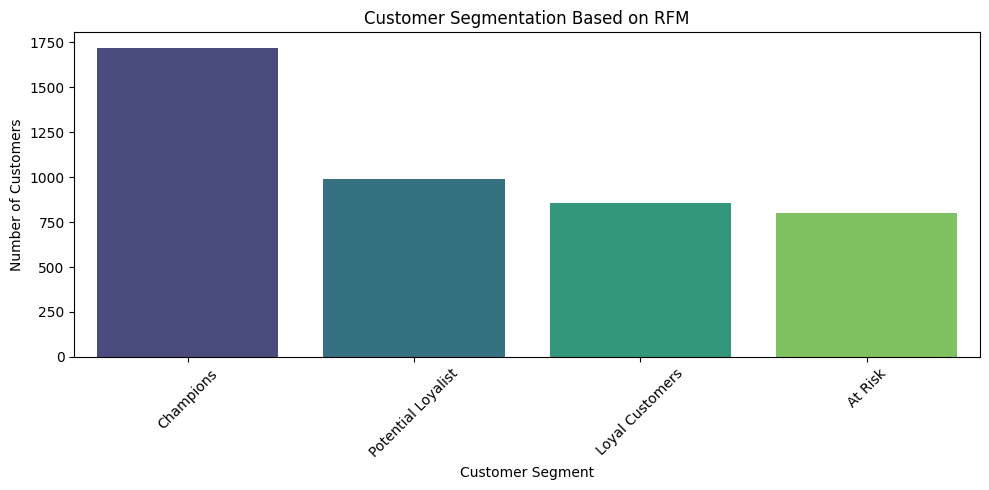

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title('Customer Segmentation Based on RFM')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


6. Optional: Heatmap of Average Monetary Value

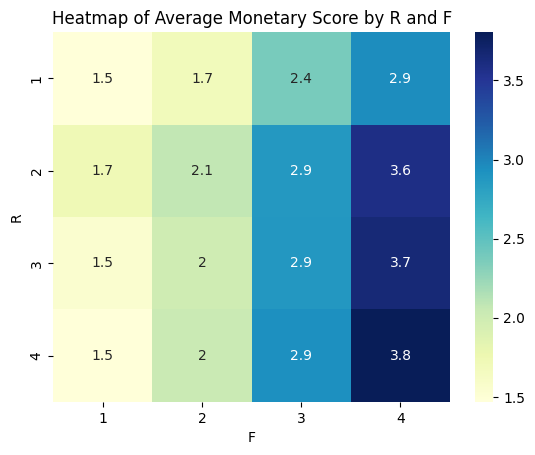

In [17]:
rfm_heatmap = rfm.pivot_table(index='R', columns='F', values='M', aggfunc='mean')
sns.heatmap(rfm_heatmap, cmap="YlGnBu", annot=True)
plt.title('Heatmap of Average Monetary Score by R and F')
plt.show()


Distribution Histograms of R, F & M

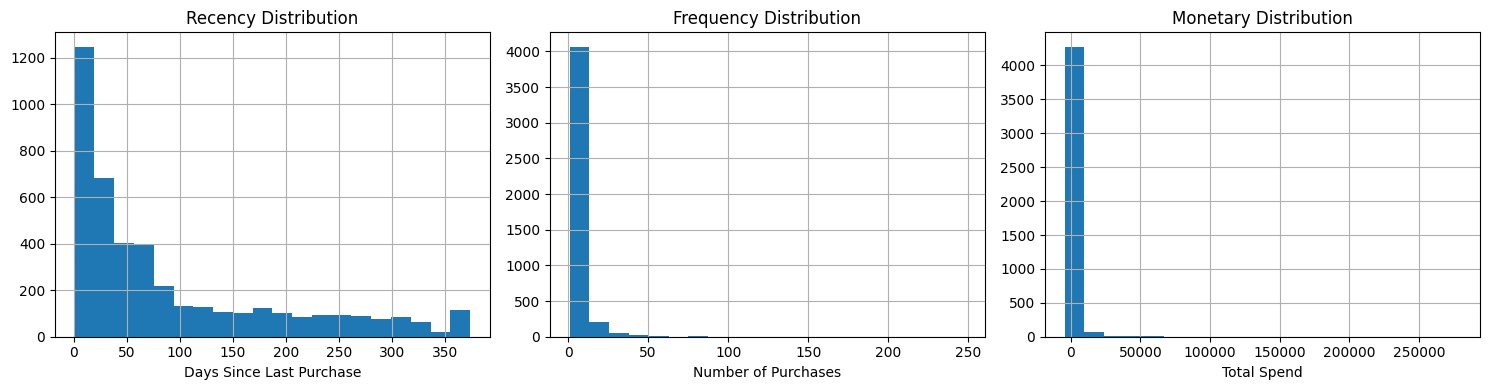

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()

rfm['Recency'].hist(ax=axes[0], bins=20)
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days Since Last Purchase')

rfm['Frequency'].hist(ax=axes[1], bins=20)
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Number of Purchases')

rfm['Monetary'].hist(ax=axes[2], bins=20)
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Total Spend')

plt.tight_layout()
plt.show()


Boxplots of R, F, M by Segment

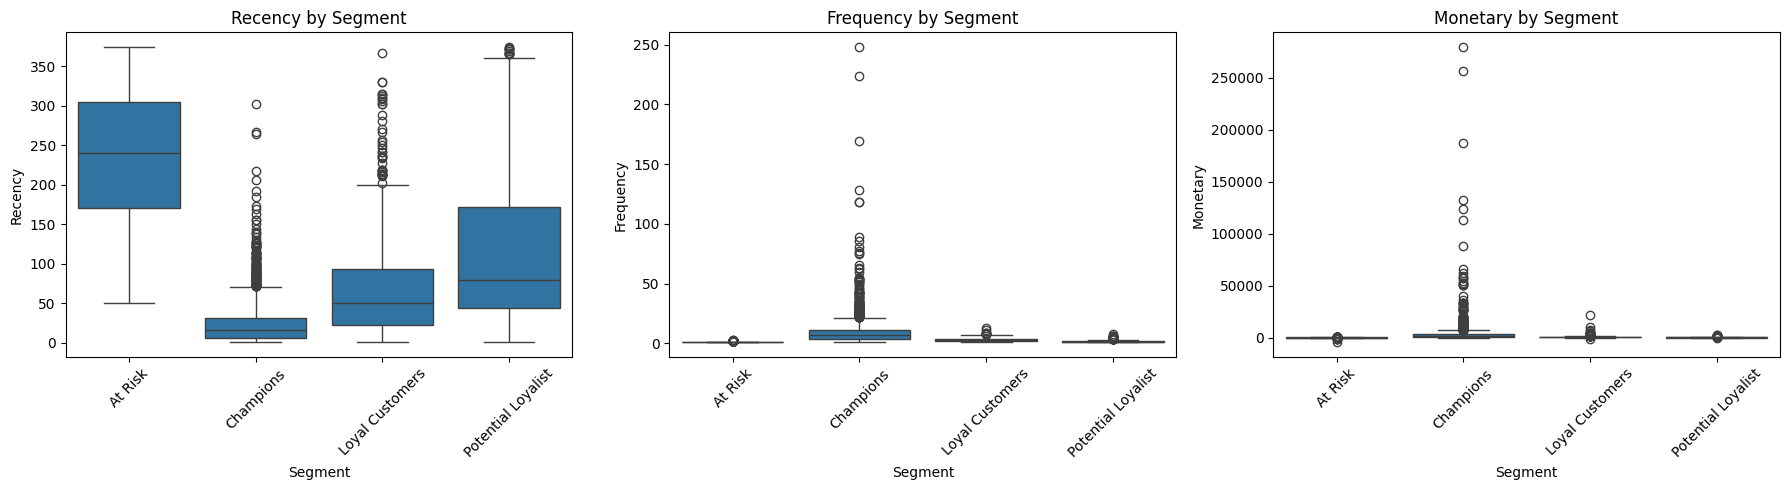

In [19]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='Segment', y='Recency', data=rfm, ax=axes[0])
axes[0].set_title('Recency by Segment')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x='Segment', y='Frequency', data=rfm, ax=axes[1])
axes[1].set_title('Frequency by Segment')
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(x='Segment', y='Monetary', data=rfm, ax=axes[2])
axes[2].set_title('Monetary by Segment')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Scatter Plot: Recency vs Frequency (colored by Segment)

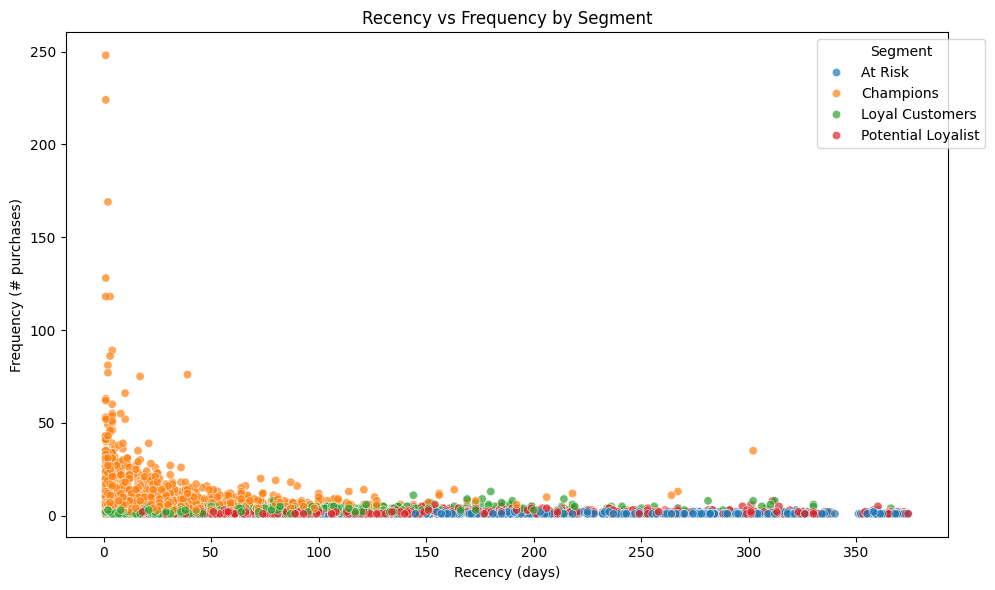

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Recency', y='Frequency',
    hue='Segment', data=rfm,
    palette='tab10', alpha=0.7
)
plt.title('Recency vs Frequency by Segment')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency (# purchases)')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


 Average R, F, M per Segment (Bar Chart)

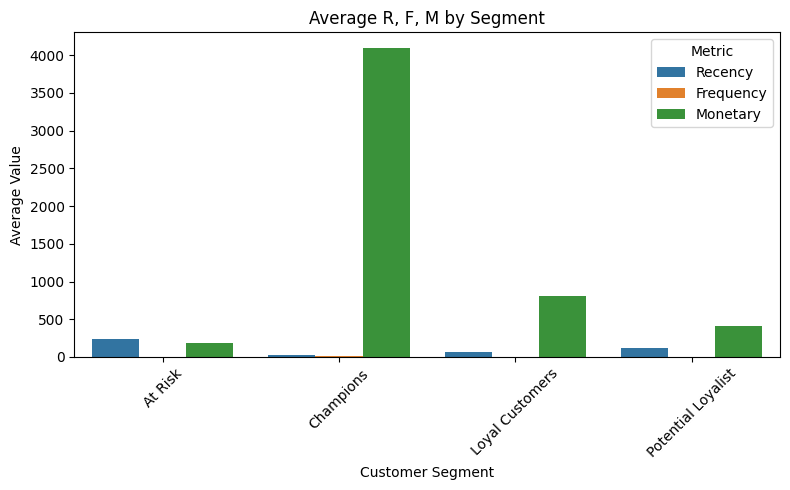

In [21]:
avg_metrics = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean().reset_index()

avg_metrics_melted = avg_metrics.melt(id_vars='Segment', var_name='Metric', value_name='Average')
plt.figure(figsize=(8, 5))
sns.barplot(x='Segment', y='Average', hue='Metric', data=avg_metrics_melted)
plt.title('Average R, F, M by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()
